------------------------

# <center> Building an e-PSF | Keck Filter J <center> 

### <center> Notebook by: Alba Rodríguez Castellano  <center> 
    

#### <center> Based on: https://photutils.readthedocs.io/en/stable/epsf.html#build-epsf  <center> 

-------------------------------

In [1]:
import astropy.io.fits
from astropy import wcs
from astropy.visualization import simple_norm
import numpy as np
from photutils.detection import find_peaks
from pathlib import Path
from astropy.nddata import CCDData
from astropy.modeling import models, fitting
from astropy.io import fits
import matplotlib.pyplot as plt
from ccdproc import ImageFileCollection

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Import the data

In [3]:
%cd /Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/combined/

directory='/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/combined/' #Put your own directory
filelist = !ls $directory/*.fits.gz

/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/Combined


In [4]:
p = Path(directory) #To place us in the directory
filelist = list(sorted(p.glob('*.fits')))
print(f'Total number of files: {len(filelist)}')
print(filelist[0:2])    # Printing only from 0 to 2

Total number of files: 3
[PosixPath('/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/combined/M82_X2_combined_K.fits'), PosixPath('/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/combined/M82_X2_combined_K1.fits')]


- Excluding 2nd night

In [5]:
keys = ['imagetyp','OBJECT' , 'EXPTIME' , 'INSFLID' , 'INSFLNAM','FILTER','DATE-OBS']
ic1 = ImageFileCollection(directory, glob_include='*.fits', keywords=keys)

matches = (ic1.summary['DATE-OBS'] =='2015-01-31') 

filelist1 = ic1.summary['file'][matches]


Continue

In [6]:
# We only want the combined image in this case ---> -1 because is the last one

HDUList_object = fits.open(filelist[-2])  #-3 combined
data_K=HDUList_object[0].data
header_K = HDUList_object[0].header

In [7]:
filelist[-2]

PosixPath('/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/combined/M82_X2_combined_K1.fits')

## 2. Define stars' coordinates

Before starting, we should have already the physical coordinates of our stars. In this case, I've collected them using the circular region option from DS9. Furthermore, to be sure that the chosen object is indeed a star we must check its **brightness profile** Region > Shape > Projection. This will display a new window in which is shown the brightness profile of the image along the line you drew (see example below of a good brightness profile).

Also, the stars can be find automatically via the ***star_finder*** function but our image is so crowdy to do this.

In [8]:
import pandas as pd

x=[736.56,933.47,689.55,743.54,442.01,962.49,326.63,919.69,665.57,901.68]
y=[671.60,451.85,454.80,862.49,651.36,564.27,850.40,680.52,797.60,495.36]

peaks_tbl=pd.DataFrame({'x':x,'y':y})

In [9]:
peaks_tbl

,x,y
0,736.56,671.60
1,933.47,451.85
2,689.55,454.80
3,743.54,862.49
4,442.01,651.36
5,962.49,564.27
6,326.63,850.40
7,919.69,680.52
8,665.57,797.60
9,901.68,495.36


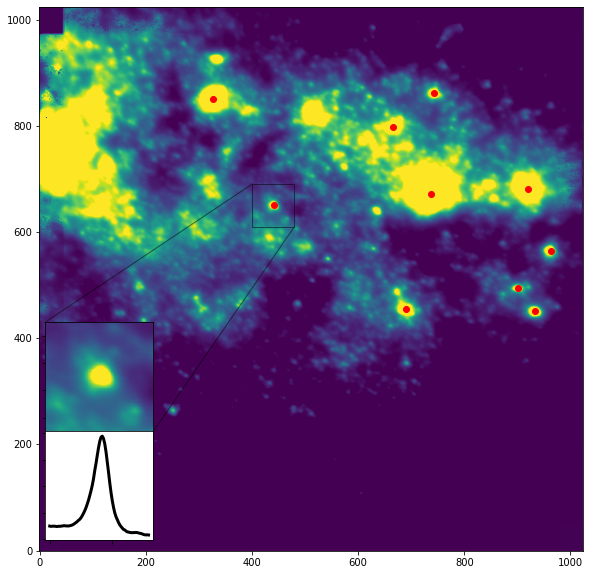

In [10]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

#In this image we display the positions of the selected stars
fig, ax = plt.subplots(figsize=[10, 10])
ax.imshow(data_K, origin='lower', cmap='viridis',vmin=0,vmax=1000)
ax.scatter(peaks_tbl['x'],peaks_tbl['y'],color='r')
#plt.plot(peaks_tbl['x'],peaks_tbl['y'],marker='.')

# inset axes....
axins = ax.inset_axes([0.01, 0.22, 0.2, 0.2])
axins.imshow(data_K, origin="lower",vmin=0,vmax=1000)

# sub region of the original image
x1, x2, y1, y2 = 400, 480, 610, 690
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

# inset axes....
axins2 = ax.inset_axes([0.01, 0.02, 0.2, 0.2])
axins2.plot(np.arange(0,len(data_K[610:690,400:480]+1)),(data_K[610:690,400:480][40]),linewidth=3,color='k')


axins2.set_xticklabels([])
axins2.set_yticklabels([])


plt.show()




## 3. Extract stars data

In [11]:
from astropy.table import Table

x = peaks_tbl['x']  
y = peaks_tbl['y'] 

stars_tbl = Table() #To do an astropy table
stars_tbl['x'] = x
stars_tbl['y'] = y

Let’s subtract the background from the image:

For info about sigma_clipping ---> https://www.gnu.org/software/gnuastro/manual/html_node/Sigma-clipping.html

In [12]:
#from astropy.stats import sigma_clipped_stats
#mean_val, median_val, std_val = sigma_clipped_stats(data_K, sigma=1)  #Sigma is the number of standard deviations 
#median_val=np.median(data_K)                                          #to use for both the lower and upper clipping limit.
                                                                       # Default=3
    
#data_K -= median_val   # we use the median to substract the background because its less affected by extreme values

The ***extract_stars()*** function requires the input data as an NDData object. The key distinction from raw *numpy.ndarray* is the presence of additional metadata such as uncertainty, mask, unit, a coordinate system and/or a dictionary containing further meta information. This class only provides a container for storing such datasets. An NDData object is easy to create from our data array:

In [13]:
from astropy.nddata import NDData
nddata = NDData(data=data_K)  

In [14]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=80)  #Size is the number of pixels. In this case 50x50

## 4. Plot the extracted stars to take a look

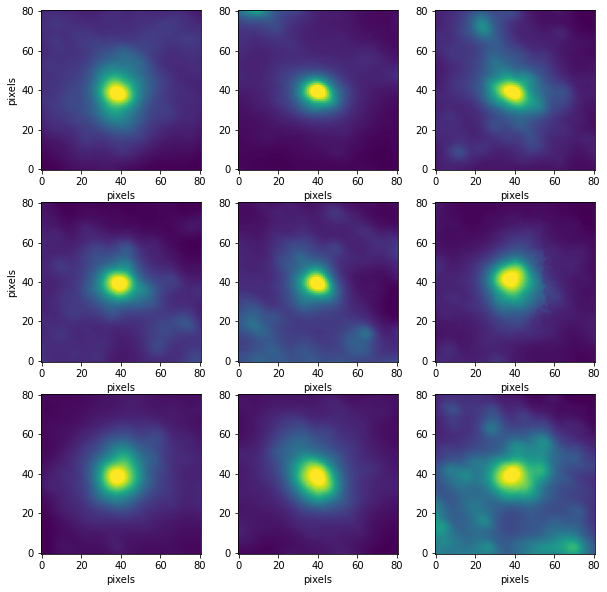

In [15]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10),squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
    ax[i].set_xlabel('pixels')
    if i==0 or i==3:
        ax[i].set_ylabel('pixels')

## 5. Calculate and plot the e-PSF

In [101]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=1, maxiters=1,progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)  

In [102]:
a=epsf.data

In [103]:
b=a/a.sum()

In [104]:
b.sum() #normalized

1.0

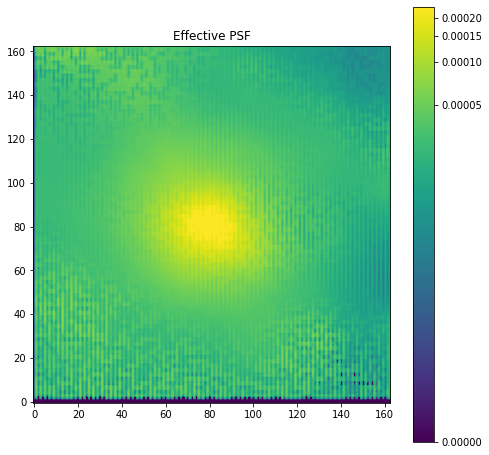

In [105]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
plt.figure(figsize=(8,8))
norm = simple_norm(b, 'log',percent=99.)
plt.imshow(b, norm=norm, origin='lower', cmap='viridis')
plt.title('Effective PSF')
plt.colorbar()

In [21]:
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc

data_image = CCDData(b,unit=u.adu)

Saving the image...

In [22]:
%cd /Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/

hdu = fits.PrimaryHDU(b)
hdul = fits.HDUList([hdu])
hdul.writeto('PSF_K1_combined.fits',overwrite='yes')

/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned


## 6. Compare the data with the model and see the residuals

In [23]:
image = fits.getdata('/Users/alba/Desktop/ESO/Data/NIRC2/calibrated/K_aligned/PSF_K1_combined.fits')

In [24]:
cents = np.where(image == np.max(image))
xc = int(cents[1])
yc = int(cents[0])

In [25]:
# Cut out smaller box around PSF
bb = 37 #MAX SIZE
box = image[yc-bb:yc+bb,xc-bb:xc+bb]
yp, xp = box.shape

In [26]:
# Generate grid of same size like box to put the fit on
y, x, = np.mgrid[:yp, :xp]
# Declare what function you want to fit to your data
f_init = models.Gaussian2D() 
# Declare what fitting function you want to use
fit_f = fitting.LevMarLSQFitter()

In [27]:
# Fit the model to your data (box)
f = fit_f(f_init, x, y, box)

In [28]:
f.x_fwhm

34.89347715519105

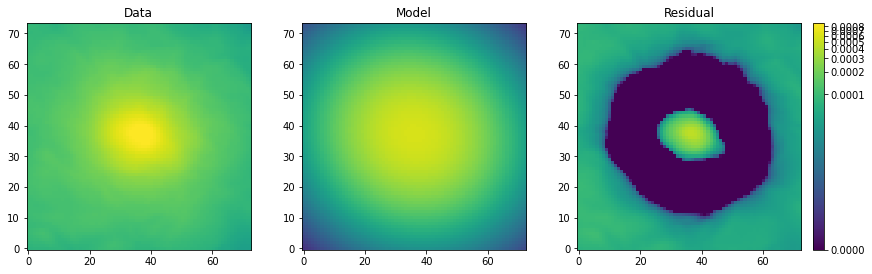

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
# Plot the data with the best-fit model
fig, (axs,axs1,axs2,cax) = plt.subplots( ncols=4,figsize=(15,15),gridspec_kw={"width_ratios":[1,1,1, 0.05]})
fig.subplots_adjust(wspace=0.3)

im= axs.imshow(box, origin='lower', cmap='viridis',norm=norm)
axs.set_title("Data")

im1= axs1.imshow(f(x, y), origin='lower', cmap='viridis',norm=norm)
axs1.set_title("Model")

im2= axs2.imshow(box - f(x, y), origin='lower', cmap='viridis',norm=norm)
axs2.set_title("Residual")

ip = InsetPosition(axs2, [1.05,0,0.05,1]) 
cax.set_axes_locator(ip)
fig.colorbar(im, cax=cax, ax=[axs,axs2])


plt.show()

In [30]:
cents = np.where(image == np.max(box))
xc = int(cents[1])
yc = int(cents[0])

In [31]:
yc

46

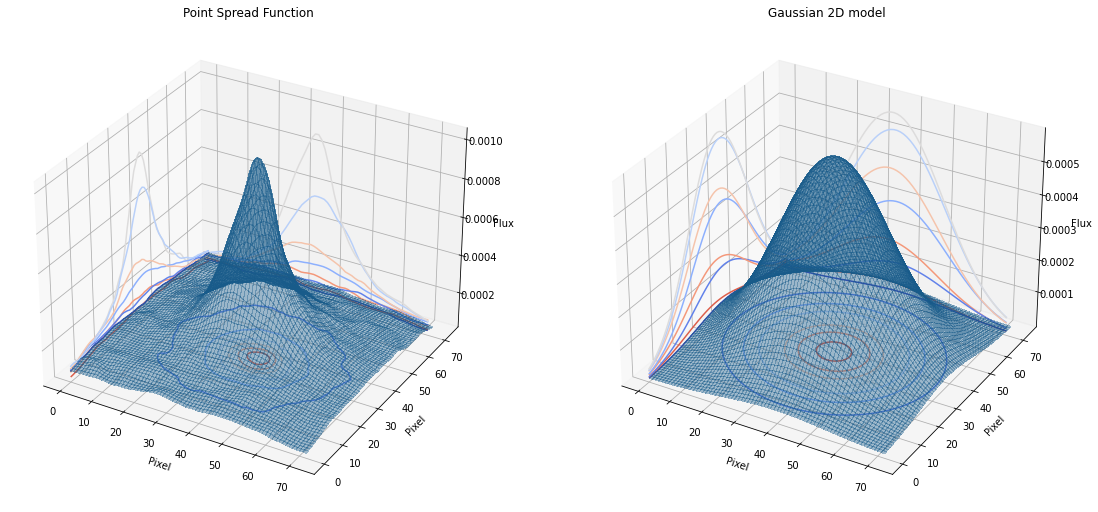

In [32]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm


fig = plt.figure(figsize=(19,19))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X, Y, Z =x, y, box
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,linewidth=0, antialiased=False,alpha=0.4)
cset = ax.contour(X, Y, Z, zdir='z', offset=0.00, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=0.003, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=70, cmap=cm.coolwarm)

ax.set_xlabel('Pixel')

ax.set_ylabel('Pixel')

ax.set_zlabel('Flux')

ax.set_title('Point Spread Function')


# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

X, Y, Z =x, y, f(x,y)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.4,linewidth=0, antialiased=False)#cmap=cm.coolwarm)

cset = ax.contour(X, Y, Z, zdir='z', offset=0.00, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=0.003, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=70, cmap=cm.coolwarm)

ax.set_xlabel('Pixel')

ax.set_ylabel('Pixel')

ax.set_zlabel('Flux')

ax.set_title('Gaussian 2D model')







plt.show()


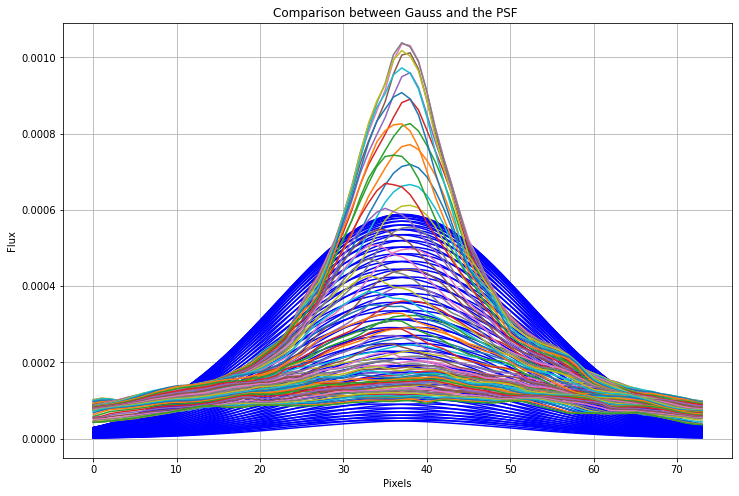

In [33]:
plt.figure(figsize=(12,8))
plt.plot(f(x, y), color='blue')
plt.plot(box)
plt.title('Comparison between Gauss and the PSF ')
plt.xlabel('Pixels')
plt.ylabel('Flux')
plt.grid()


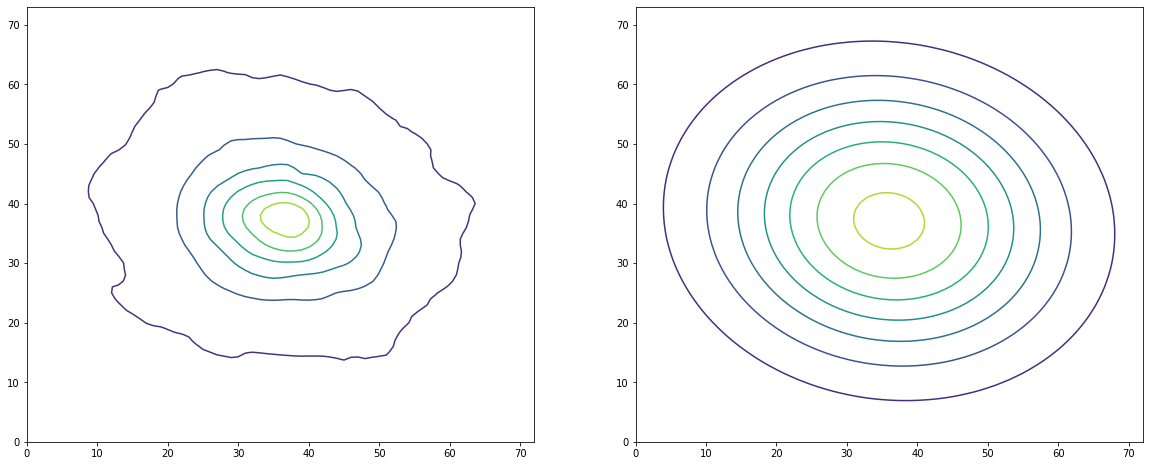

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8),squeeze=True)
ax[1].contour(f(x,y))
ax[0].contour(box)
plt.show()